This notebook runs an ILP solver to genotype a read count matrix consisting of cells as rows and genomic positions as columns. As the post processing steps, the perfect phylogeny is constructed and displayed 

#  Import required packages

In [1]:
import numpy as np 
from gurobipy import *
import copy
import sys
from sys import maxint
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# plt.switch_backend('agg')
import random
import math
import scipy
import subprocess
from scipy.stats import *
from scipy.special import comb
from scipy.special import gammaln
from ete3 import Tree
import time 
from cdecimal import Decimal
import numpy as np 
from ete3 import Tree, TreeStyle
import scipy.cluster.hierarchy as hier
import scipy.spatial.distance as dist
from sklearn.cluster import KMeans
from memory_profiler import memory_usage
from IPython.display import Latex

# Required functions

The first one is the function to calculate the binomial probability mass function. 

In [2]:
def Binomial_pmf(k,n,p):
	k_decimal = Decimal(k)
	n_decimal = Decimal(n)
	p_decimal = Decimal(p)
	tmp = Decimal(gammaln(n+1)-gammaln(k+1)-gammaln(n-k+1))+Decimal(k_decimal*p_decimal.ln()+(n_decimal-k_decimal)*Decimal(1-p_decimal).ln())
	return tmp.exp()

def beta_function(alpha, beta, r, v):

	tmp = Decimal((Decimal(gammaln(r+v+1))-Decimal(gammaln(v+1))-Decimal(gammaln(r+1)))+(Decimal(gammaln(alpha+v))+Decimal(gammaln(beta+r))-Decimal(gammaln(alpha+v+beta+r)))+(-Decimal(gammaln(alpha))-Decimal(gammaln(beta))+Decimal(gammaln(alpha+beta))))
	return tmp.exp()

This function checks the duplicates among the cells after inference because PerfectPhy does not return the duplicated cells

In [3]:
def duplicates(lst, item):
	return [i for i, x in enumerate(lst) if x == item]

This function checks the final result to make sure all the mutations hold Perfect Phylogeny assumption

In [4]:
def check_InCompatibility(Matrix):

	###### Count the number of character pairs which violate the 
	###### infinite-sites assumption
	num_incompatibles = 0
	Matrix = np.array(Matrix)
	n = Matrix.shape[0]
	l = Matrix.shape[1]
	B_prime = [[[0 for k in range(4)] for j in range(l)] for i in range(l)]
	for p in range(l):
		q = p+1
		while q<l:
			for cell in range(n):
				# if Matrix[cell][p]==0 and Matrix[cell][q]==0:
				# 	B_prime[p][q][0]=1
				if Matrix[cell][p]==0 and Matrix[cell][q]==1:
					B_prime[p][q][1]=1
				elif Matrix[cell][p]==1 and Matrix[cell][q]==0:
					B_prime[p][q][2]=1
				elif Matrix[cell][p]==1 and Matrix[cell][q]==1:
					B_prime[p][q][3]=1
			q+=1
	S = set()
	for p in range(l):
		q=p+1
		while q<l:
			s = sum(B_prime[p][q])
			if s==3:
				num_incompatibles+=1
				S.add(p)
				S.add(q)
			q+=1
	S = list(S)
	return num_incompatibles

Functions to read and parse the mpileup format

In [5]:
def match(str):
	tmp = 0
	tmp+=str.count(",")
	tmp+=str.count(".")
	return tmp
def mismatch(str):
	tmp=0
	tmp+=str.count("A")
	tmp+=str.count("C")
	tmp+=str.count("G")
	tmp+=str.count("T")
	tmp+=str.count("N")
	tmp+=str.count("a")
	tmp+=str.count("c")
	tmp+=str.count("g")
	tmp+=str.count("t")
	tmp+=str.count("n")
	return tmp

# Integer Linear Programming optimization


The input of the optimizer is a matrix of reference/variant counts for of n cells and m genomic positions. The objective of the ILP solver is to minimize the negative log-likelihood of the following function:
%%latex
\begin{equation}
\prod^{n}_{i}\prod^{m}_{j} \Pr(r_{ij},v_{ij}|Y_{ij})=( \operatorname{Bin}_{i,j}(\mu_{1})\alpha+ \operatorname{Bin}_{i,j}(\mu_{0})(1-\alpha))^{(1-Y_{ij})}( \operatorname{Bin}_{i,j}(\mu_{1})(1-\beta)+\operatorname{Bin}_{i,j}(\mu_{0})\beta)^{Y_{ij}}
\end{equation}
Where $\alpha$ and $\beta$ are the false positive and false negative sequencing error (given to the method), $\operatorname{Bin}_{i,j}(\mu_{1})$ and $\operatorname{Bin}_{i,j}(\mu_{0})$ are the binomial distributions associated with observed mutated and non-mutated nucleotide counts, respectively. $Y_{ij}$'s are integer variables indicating the genotype of each entry in the inferred genotyped matrix. These integer variables are constrained by some inequalities which guarantee the Perfect Phylogeny assumption.

In [7]:
def optimize(read_counts,fp,fn,missing_data_thr,R):
    
    #########################################################################################################################
    ############ The arguments include the error rates, the read count matrix, and the threshold for missing data ###########
    #########################################################################################################################
	fp_decimal = fp
	fn_decimal = fn
	n = read_counts.shape[0]
	l = read_counts.shape[1]
	missing_data_threshold = missing_data_thr
	weights = np.zeros(read_counts.shape)
	######################################################################
	######################### Build the model ############################
	######################################################################
	model = Model("model")

	B = {}
	Y = []
	########################################
	### Add the variables to the model #####
	########################################
	print("Add variables to the model")
	for i in range(n):
		Y.append([])
		for j in range(l):
			Y[i].append(model.addVar(vtype=GRB.BINARY, name="Y[%d,%d]" % (i,j)))

	for p in range(l):
		q=p+1
		while q<l:
			for k in range(3):
				B["("+str(p)+","+str(q)+","+str(k+1)+")"]=model.addVar(vtype=GRB.BINARY, name="B["+str(i)+","+str(j)+","+str(k+1)+"]")
			q+=1
	model.update()

	######################################
	### Add constraints to the model #####
	######################################
	print("Add constraints to the model")
	for p in range(l):
		q=p+1
		while q<l:
			model.addConstr(2>=B["("+str(p)+","+str(q)+","+str(1)+")"]+B["("+str(p)+","+str(q)+","+str(2)+")"]+B["("+str(p)+","+str(q)+","+str(3)+")"])
			for taxon in range(n):
				####### The constraints which control the B variables #######
				model.addConstr(B["("+str(p)+","+str(q)+","+str(1)+")"]>=Y[taxon][q]-Y[taxon][p])
				model.addConstr(B["("+str(p)+","+str(q)+","+str(2)+")"]>=Y[taxon][p]-Y[taxon][q])
				model.addConstr(B["("+str(p)+","+str(q)+","+str(3)+")"]>=Y[taxon][p]+Y[taxon][q]-1)
			q=q+1

	mu0=1e-3
	mu1=0.1
	mu2=0.5
	#################################################################
	################ Build the objective function ###################
	#################################################################
	m_num = 0
	print("Build the objective function")

	obj = LinExpr()
	for i in range(n):
		for j in range(l):
            ############# This line accounts for the missing data ##############
			if read_counts[i][j][0]+read_counts[i][j][1]>=missing_data_threshold: 
				r = read_counts[i][j][0]
				v = read_counts[i][j][1]
				AA = Binomial_pmf(v,r+v,mu0)
# 				BB = Binomial_pmf(v,r+v,mu1)
				BB = Decimal(0.5)*Binomial_pmf(v,r+v,mu1)+Decimal(0.5)*Binomial_pmf(v,r+v,mu2)

				obj -= (Y[i][j])*np.float128(Decimal((fn_decimal/2)*AA+(1-fn_decimal/2)*BB).ln())
				obj -= (1-Y[i][j])*np.float128(Decimal((1-fp_decimal)*AA+(fp_decimal)*BB).ln())
        
				weights[i][j] = [-np.float128(Decimal(1-(1-fp_decimal)*AA-(fp_decimal)*BB).ln()),-np.float128(Decimal(1-(fn_decimal/2)*AA-(1-fn_decimal/2)*BB).ln())]

				
			else:
				weights[i][j] = [-1,-1]
				m_num+=1

	model.update()
	##################################################
	########## Assign the objective function #########
	##################################################
	print("Assign the objective function")
	model.setObjective(obj, GRB.MINIMIZE)

	#####################################################
	######## Set the parameters of the model ############
	#####################################################
	#model.Params.timeLimit = 255000
	# model.Params.method=3
	#model.Params.Threads = 31
	#model.Params.ConcurrentMIP = 2
	model.Params.MIPGap=0.0

	########################################################
	######### Optimize the model and report it #############
	########################################################
	print("percentage of missing data %f" %(100*float(m_num)/float(n*l)))
	print("Optimize the model")
	model.optimize()
	print('IsMIP: %d' % model.IsMIP)
	if model.status == GRB.Status.INFEASIBLE:
		print "The model is infeasible"

	print("Solved with MIPFocus: %d" % model.Params.MIPFocus)
	print("The noisy model has been optimized")
	print('Obj: %g' % model.objVal)


	#########################################################
	##### Save the final array given by the ILP solver ######
	#########################################################
	for i in range(n):
		for j in range(l):
			R[i][j] = int(Y[i][j].x)

	gc.collect()
	return

# Main pipeline begins 

Parse the file containing the cell names. The cell names are of the form "Cell40 CT" in which the first term is the cell name and the second one is the cell type (which could be used for further analysis)

In [8]:
names_file= open("cellNames.txt","r")
names = []
arr_names = names_file.readlines()
names_file.close()
for line in arr_names:
	tmp = line.strip().split("\t")
	names.append(tmp[0].replace("cell",""))
print("# of cells %d" %len(names))

# of cells 370


Specify the error rates and other variables

In [9]:
nmc = 2 ## Number of cells which need a minimum coverage which support the alternative
ms = 3 ## Minimum number of reads required to support the alternative
missing_data_threshold = 1
fn_given = 0.0
fp_given = 0.0

Parse the mpileup file 

In [10]:
pileup = open("ovarian.mpileup","r")

read_counts = []
ILP_positions = []
num_cells = len(names)
for i in range(num_cells):
	read_counts.append([])

print("Parse the mpileup file")	
pile_arr = pileup.readlines()
pileup.close()
for line in pile_arr:
	tmp_arr = []
	nmc_count = 0
	current_pos = int(line.strip().split('\t')[1])
	split = line.strip().split('\t')[3:]
	for i in range(num_cells):
		if int(split[3*i])==0:
			tmp_arr.append([0,0])
		else:
			tmp_arr.append([match(split[3*i+1]),mismatch(split[3*i+1])])
			if mismatch(split[3*i+1])>=ms:
				nmc_count+=1

	if nmc_count>=nmc:
		ILP_positions.append(current_pos)
		for i in range(num_cells):
			read_counts[i].append(tmp_arr[i])

read_counts=np.array(read_counts)
n=read_counts.shape[0]
l=read_counts.shape[1]

del pile_arr
gc.collect()
print("Read count data is ready")
print("# of taxa: %d" % n)
print("# of mutations: %d" % l)

Parse the mpileup file
Read count data is ready
# of taxa: 370
# of mutations: 43


Add some noise to the given sequencing error rates

In [11]:
mu=1
sigma=0.1
coeff = 2.5
while coeff>=2 or coeff<=0.5:
	coeff = np.random.normal(mu,sigma)
fn = fn_given*coeff 
coeff = 2.5
while coeff>=2 or coeff<=0.5:
	coeff = np.random.normal(mu,sigma)
fp = fp_given*coeff

print("false positive rate given: %f" %fp)
print("false negative rate given: %f" %fn)
fp_decimal = Decimal(fp)
fn_decimal = Decimal(fn)

false positive rate given: 0.000000
false negative rate given: 0.000000


# Run Gurobi on the read count matrix

In [12]:
start_time=time.time()
R = [[0 for j in range(l)] for i in range(n)]
optimize(read_counts,fp_decimal,fn_decimal,missing_data_threshold,R)
print("--- %s seconds ---" % (time.time() - start_time))

Academic license - for non-commercial use only
Add variables to the model
Add constraints to the model
Build the objective function
Assign the objective function
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
percentage of missing data 5.556254
Optimize the model
Optimize a model with 1003233 rows, 18619 columns and 3009699 nonzeros
Variable types: 0 continuous, 18619 integer (18619 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 7.293965e+07
Presolve time: 4.26s
Presolved: 1003233 rows, 18619 columns, 3009699 nonzeros
Variable types: 0 continuous, 18619 integer (18619 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2939655e+07   6.824

  126451    5.6461600e+06   1.439632e+08   0.000000e+00    571s
  126691    5.6461599e+06   1.764565e+08   0.000000e+00    577s
  126931    5.6461598e+06   1.618232e+08   0.000000e+00    582s
  127051    5.6461597e+06   9.698282e+07   0.000000e+00    585s
  127411    5.6461595e+06   6.155793e+08   0.000000e+00    593s
  127531    5.6461594e+06   1.344055e+08   0.000000e+00    595s
  127771    5.6461592e+06   1.855443e+08   0.000000e+00    601s
  128011    5.6461590e+06   6.629496e+07   0.000000e+00    606s
  128251    5.6359143e+06   2.627229e+08   0.000000e+00    611s
  128581    5.6359141e+06   1.056037e+08   0.000000e+00    617s
  128711    5.6359140e+06   1.832065e+08   0.000000e+00    620s
  128951    5.6359139e+06   6.556734e+07   0.000000e+00    625s
  129191    5.6359138e+06   1.242396e+08   0.000000e+00    631s
  129431    5.6359137e+06   1.150432e+08   0.000000e+00    637s
  129671    5.6359136e+06   1.289730e+08   0.000000e+00    642s
  129791    5.6359136e+06   7.681277e+07

  156317    5.5401791e+06   1.395356e+08   0.000000e+00   1216s
  156527    5.5401790e+06   4.791165e+07   0.000000e+00   1221s
  156737    5.5400403e+06   7.964899e+07   0.000000e+00   1225s
  157101    5.5381282e+06   1.254266e+07   0.000000e+00   1232s
  157311    5.5381280e+06   1.140702e+08   0.000000e+00   1237s
  157511    5.5381280e+06   1.326720e+08   0.000000e+00   1242s
  157755    5.5368979e+06   1.658448e+07   0.000000e+00   1246s
  157955    5.5368979e+06   4.771415e+07   0.000000e+00   1251s
  158155    5.5368978e+06   1.165836e+07   0.000000e+00   1256s
  158465    5.5363405e+06   5.750925e+07   0.000000e+00   1262s
  158665    5.5363404e+06   5.976719e+07   0.000000e+00   1267s
  158865    5.5363403e+06   2.643439e+07   0.000000e+00   1271s
  159075    5.5363403e+06   2.554243e+07   0.000000e+00   1277s
  159285    5.5363402e+06   6.822988e+07   0.000000e+00   1282s
  159485    5.5350091e+06   1.706239e+08   0.000000e+00   1286s
  159685    5.5350091e+06   1.782010e+07

     0     0 5525634.76    0  482 5529159.58 5525634.76  0.06%     - 2463s
     0     0 5525739.45    0  439 5529159.58 5525739.45  0.06%     - 2466s
     0     0 5525744.73    0  426 5529159.58 5525744.73  0.06%     - 2470s
     0     0 5525747.21    0  433 5529159.58 5525747.21  0.06%     - 2472s
     0     0 5525747.59    0  430 5529159.58 5525747.59  0.06%     - 2473s
     0     0 5525767.69    0  440 5529159.58 5525767.69  0.06%     - 2475s
     0     0 5525785.68    0  443 5529159.58 5525785.68  0.06%     - 2478s
     0     0 5525785.73    0  443 5529159.58 5525785.73  0.06%     - 2478s
     0     0 5525809.97    0  443 5529159.58 5525809.97  0.06%     - 2483s
     0     0 5525813.47    0  395 5529159.58 5525813.47  0.06%     - 2486s
     0     0 5525815.72    0  393 5529159.58 5525815.72  0.06%     - 2487s
     0     0 5525817.21    0  397 5529159.58 5525817.21  0.06%     - 2488s
     0     0 5525817.66    0  395 5529159.58 5525817.66  0.06%     - 2489s
     0     0 5526159.43  

     0     0 5527982.63    0  396 5529004.11 5527982.63  0.02%     - 2735s
     0     0 5527983.22    0  384 5529004.11 5527983.22  0.02%     - 2736s
     0     0 5527983.76    0  382 5529004.11 5527983.76  0.02%     - 2736s
     0     0 5527989.03    0  391 5529004.11 5527989.03  0.02%     - 2737s
     0     0     cutoff    0      5529004.11 5529004.11  0.00%     - 2745s

Explored 1 nodes (1839542 simplex iterations) in 2745.75 seconds
Thread count was 4 (of 4 available processors)

Solution count 6: 5.529e+06 5.52904e+06 5.52916e+06 ... 7.29397e+07

Optimal solution found (tolerance 0.00e+00)
Best objective 5.529004107809e+06, best bound 5.529004107809e+06, gap 0.0000%
IsMIP: 1
Solved with MIPFocus: 0
The noisy model has been optimized
Obj: 5.529e+06
--- 2779.90334201 seconds ---


# Post processing steps 

Plotting the read counts with labels (mutated and non-mutated)

(8463, 2)
(7447, 2)


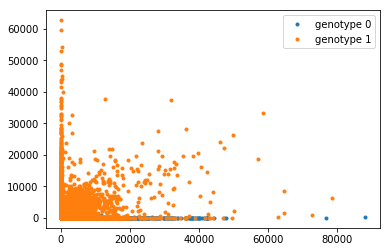

In [13]:
for k in range(2):
    arr = []
    for i in range(n):
        for j in range(l):
            if R[i][j]==k:
                arr.append(read_counts[i][j])
    arr = np.array(arr)
    print arr.shape
    plt.plot(arr[:,0],arr[:,1],'.',label='genotype %d' %k)
plt.legend()

Add one cell as the normal case (containing only non-mutated genomic positions) and plot the heatmap 

(370, 43)


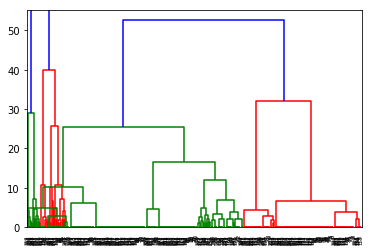

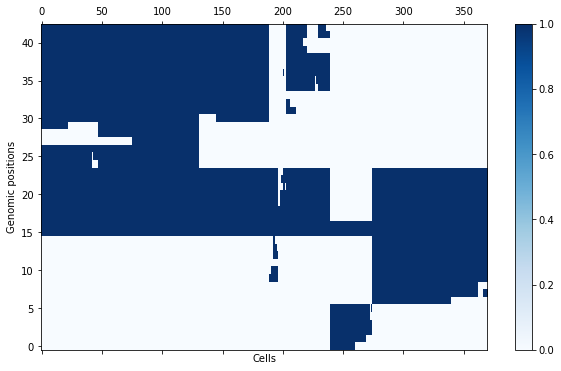

In [14]:
# names.append(str(len(names)))
# R.append([0 for i in range(l)])
# print names
R = np.array(R)
# R = np.delete(R,(-1),axis=0)
print R.shape

tmp_array = copy.copy(R)
R1 = tmp_array.T
distMatrix = dist.pdist(R1)
distSquareMatrix = dist.squareform(distMatrix)
linkageMatrix = hier.linkage(distMatrix,method='ward')
dendro = hier.dendrogram(linkageMatrix)
leaves = dendro['leaves']
transformedData = R1[leaves,:]


R2=tmp_array
distMatrix = dist.pdist(R2)
distSquareMatrix = dist.squareform(distMatrix)
linkageMatrix = hier.linkage(distMatrix,method='ward')
dendro = hier.dendrogram(linkageMatrix)
leaves2 = dendro['leaves']
transformedData = transformedData[:,leaves2]

fig_final = plt.figure(figsize=(10,6))
ax_final = fig_final.add_subplot(111)
cax_final = ax_final.matshow(transformedData, origin='lower',cmap='Blues',aspect="auto")
ax_final.set_xlabel('Cells')
ax_final.set_ylabel('Genomic positions')
fig_final.colorbar(cax_final)
# fig_final.show()
fig_final.savefig("profiles_ILP.png")

Remove the genomic positions with only one genotype (redundants)

In [15]:
###########################################################################################
###################### Remove the columns with only one state #############################
###########################################################################################

removal_R = []
num_of_char = 2 ## This is a binary case
for j in range(l):

	result_count = len(set(R[:,j]))

	if result_count<num_of_char:
		removal_R.append(j)

print(str(len(set(removal_R)))+" characters have been removed from the result")

R = np.delete(R, removal_R, 1)
#### The number of columns has changed
n = len(R)
l_R_removal = len(R[0])

2 characters have been removed from the result


In [16]:
############################ Second Post Processing Step ###############################
#### Build the input matrix of PerfectPhy without columns containing only 0s or 1s #####
########################################################################################

result_name = "./PerfectPhy/src/tree_result.txt"
result_newick = "./result_newick.nwk"

cmd = 'rm '+result_name
os.system(cmd)
cmd ='rm '+result_newick
os.system(cmd)

tree_result = open(result_name, "w")

tree_result.write("0"+"\n")

tree_result.write(str(n)+"\t"+str(l_R_removal)+"\n")

In [17]:
####################### Third Post Processing Step ###############################
################## Find the duplicated taxa in matrix/matrices ###################
##################################################################################

R_taxa = []
for i in range(n):
	temp2 = ""
	for j in range(l_R_removal):
		temp2+=str(R[i][j])
		
	R_taxa.append(temp2)

R_taxa=np.array(R_taxa)

##########################################################
####### Prepare the input file/files of PerfectPhy #######
##########################################################

for i in range(n):

	for j in range(l_R_removal):
		if j==l_R_removal-1 and i!=n-1:
			tree_result.write(str(R[i][j])+"\n")
		elif j==l_R_removal-1 and i==n-1:
			tree_result.write(str(R[i][j]))
		else:
			tree_result.write(str(R[i][j])+"\t")
tree_result.close()


# Build the perfect phylogeny and display it

Construct the perfect phylogeny (if it exists) using PerfectPhy 

In [18]:
###################### Fourth Post Processing Step ############################
######### Construct the perfect phylogeny using PerfectPhy ####################
###############################################################################


p_method = subprocess.Popen('./PerfectPhy/src/perfectphy -f '+result_name+' -newick', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
data_method = ""
for line in p_method.stdout.readlines():
	data_method=line
retval = p_method.wait()
data_method = data_method.replace(" ","")+";"

p2_method = subprocess.Popen('./PerfectPhy/src/perfectphy -f '+result_name+' -unique', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

print("uniqueness of perfect phylogeny of the Inferred Tree:")
for line in p2_method.stdout.readlines():
	print line
##################### Build a Tree object from Newick(s) #######################
tree_method = Tree(data_method, format=8)

for leaf in tree_method:
	if leaf.name.replace("'","") in R_taxa:
		tmp_tuple = tuple(duplicates(R_taxa,leaf.name.replace("'","")))
		leaf.add_child(name=str(tmp_tuple[0]+1))
		for new_node in tmp_tuple[1:]:
			leaf.add_child(name=str(new_node+1))
for leaf in tree_method:
	leaf.name = names[int(leaf.name)-1]
######## Name the internal nodes #############

extra_R = n+1
ntax = 0
for node in tree_method.traverse("postorder"):
	ntax+=1
	if not node.is_leaf():
		node.name = "internal_"+str(extra_R)
		extra_R+=1

data_method_write = tree_method.write(format=8)

uniqueness of perfect phylogeny of the Inferred Tree:
1 The data DOES have a perfect phylogeny

1 Phylogeny is unique!



Display the phylogenetic tree

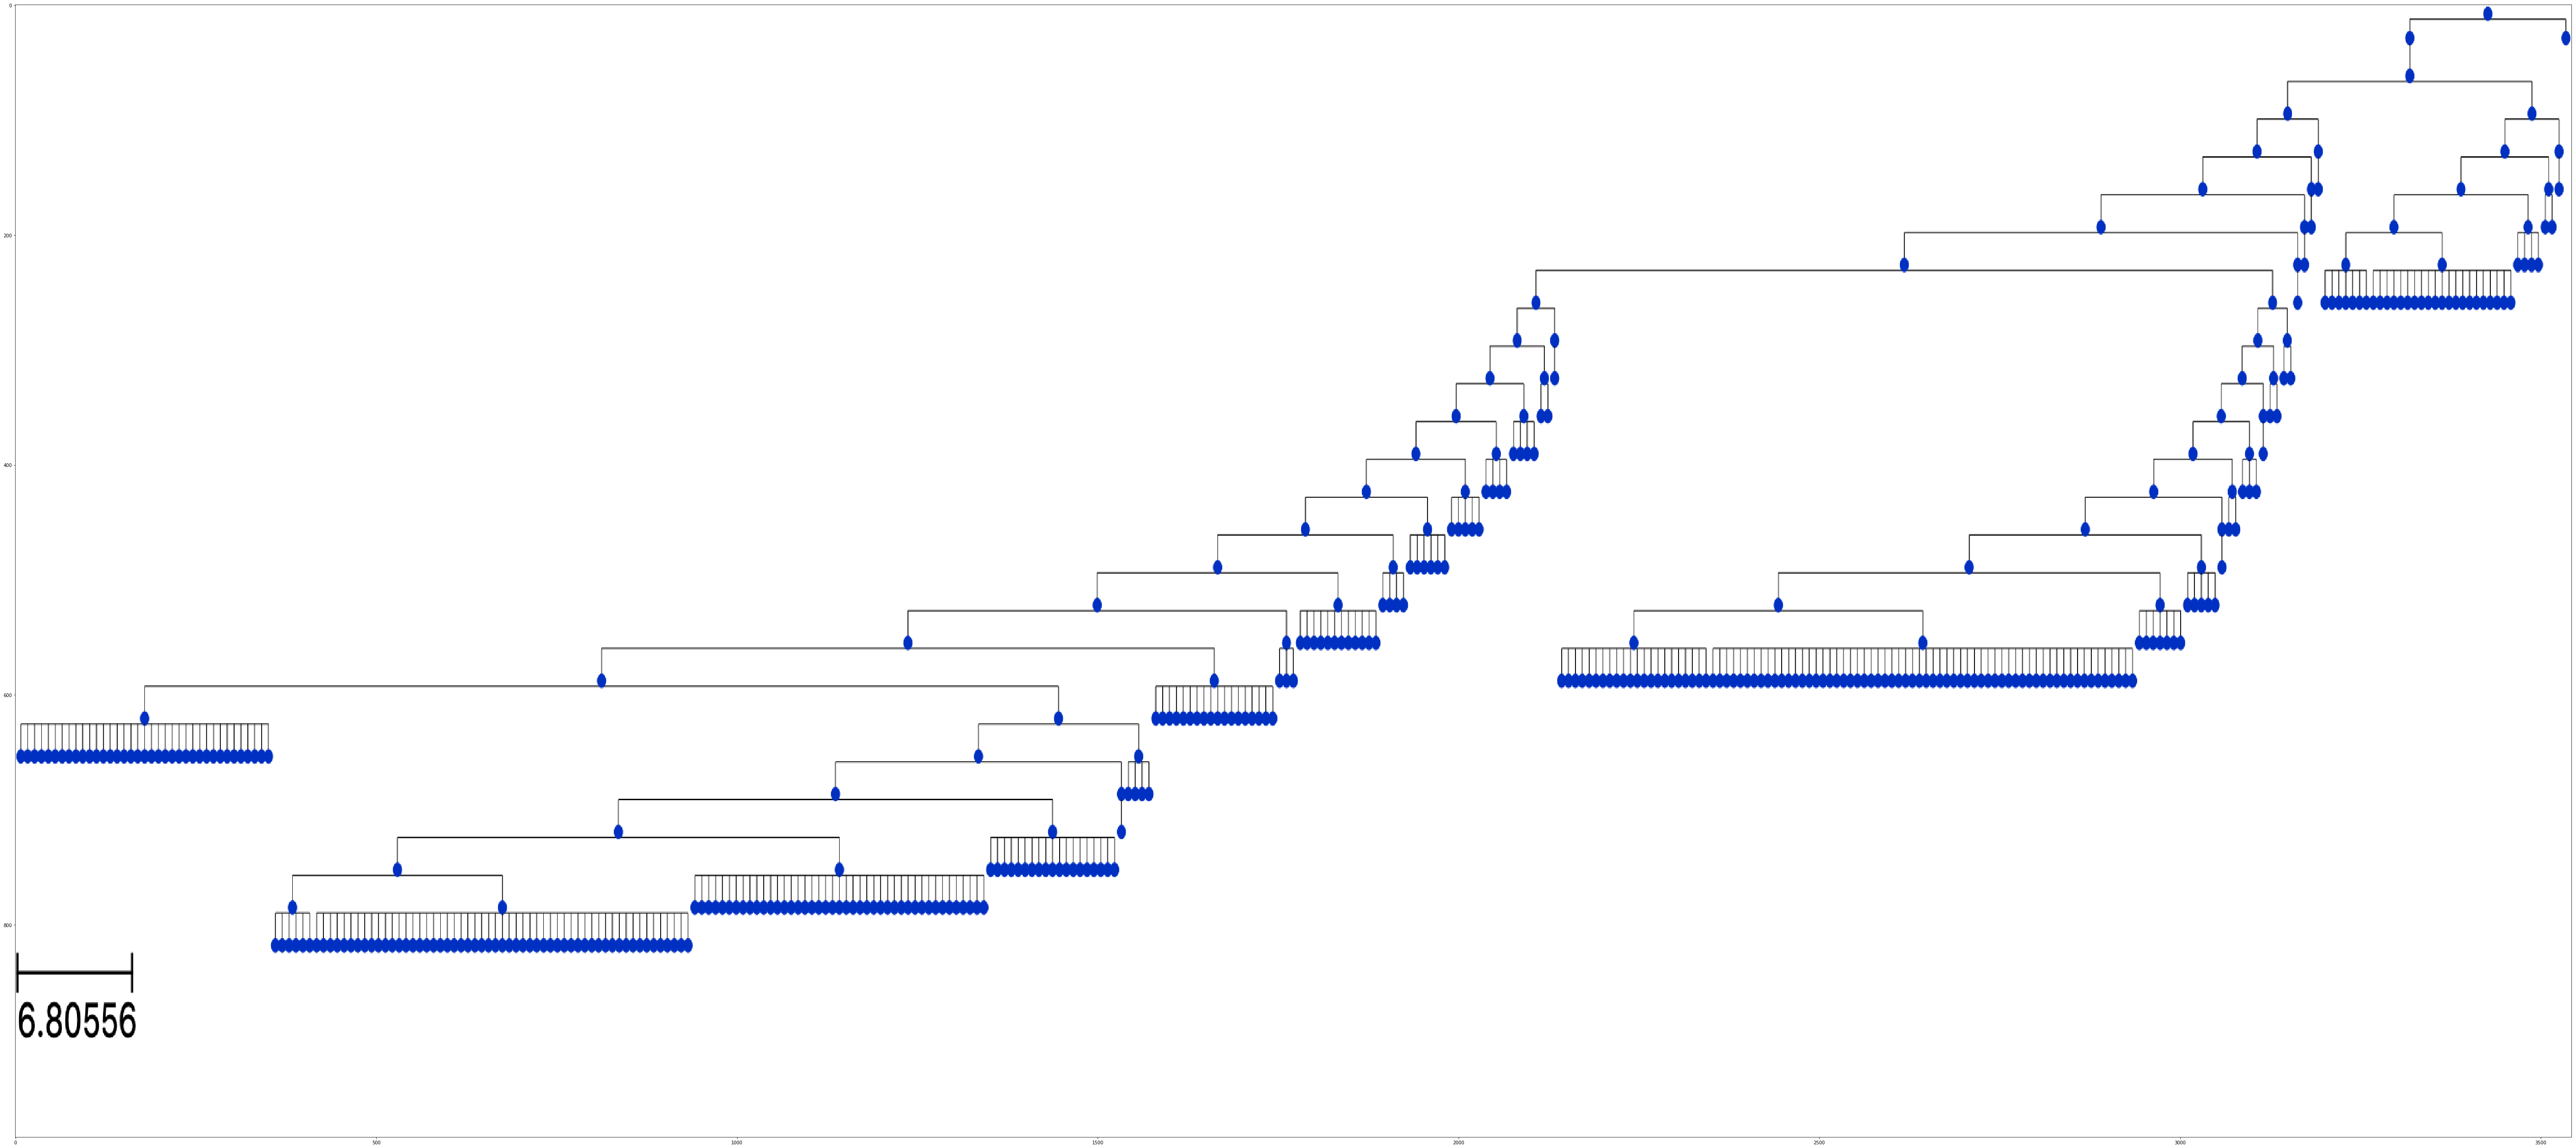

In [19]:
tree_method.set_outgroup(tree_method&str(len(names)-1))
circular_style = TreeStyle()
# circular_style.mode = "c" # draw tree in circular mode
# circular_style.scale = 10
circular_style.show_leaf_name = True
circular_style.rotation = 90
# circular_style.branch_vertical_margin = 10
# circular_style.arc_start = -180 # 0 degrees = 3 o'clock
# circular_style.arc_span = 180
tree_method.render("mytree.png", w=1000,units='mm',dpi=5000, tree_style=circular_style)
img = mpimg.imread('mytree.png')
# plt.imshow(img, aspect='auto')
# plt.show()
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(2, 1, 1)
ax.imshow(img,aspect='auto')

# Write the NEXUS format file for further visualization and analysis

In [20]:
############################################################################
#################### Generate the nexus format file ########################
############################################################################

trees = open(result_newick, "w")
trees.write("#NEXUS"+"\n")
trees.write("begin taxa;"+"\n")
trees.write("dimensions ntax="+str(ntax)+";"+"\n")
trees.write("taxlabels"+"\n")
for node in tree_method.traverse("postorder"):
	trees.write(node.name+"\n")

trees.write(";"+"\n")
trees.write("end;"+"\n")
trees.write("Begin trees;"+"\n")

trees.write("Tree 'PAUP_Inferred' = [&U] ")
trees.write(data_method_write+"\n")
trees.write("END;")

trees.close()